<table width="100%" style="padding:0; margin-left:-6px;">
    <tr style="padding=0;" width="100%">
        <td width="auto">
           <hr style="border:2px solid darkblue">
            <h1> nb4. Query by scientific category</h1>
           <hr style="border:2px solid darkblue">
        </td>
        <td width="60px">
           <img src="ALMAsmall.png" align="right"/> 
        </td>
    </tr>
</table>    

The relevant columns in the ALMA TAP service are:
* *science_category* 
* *science_keyword*
 
--------- ----- -----

The scientific categories of observations in ALMA are the more general groups. These are:
* Active galaxies
* Cosmology
* Disks and planet formation
* Galaxy evolution
* ISM and star formation
* Local Universe
* Solar system
* Stars and stellar evolution
* Sun



In [1]:
import numpy as np
from astropy.table import Table
import pyvo
import sys
import matplotlib.pyplot as plt
import pandas as pd

service = pyvo.dal.TAPService("https://almascience.eso.org/tap")      # for the EU ALMA TAP service

# service = pyvo.dal.TAPService("https://almascience.nao.ac.jp/tap")  # for the EA ALMA TAP service
# service = pyvo.dal.TAPService("https://almascience.nrao.edu/tap")   # for the NA ALMA TAP service

<hr style="border:2px solid darkblue"> </hr>


## Query scientific category
<hr style="border:2px solid darkblue"> </hr>



In [7]:
def query_scientific_category(scientific_category):
    """Query for all observations of a given scientific category"""
    
    query = f"""  
            SELECT  * 
            FROM ivoa.obscore  
            WHERE scientific_category = '{scientific_category}'  
            AND science_observation = 'T'  
            """

    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>


## Query science keyword and data type
<hr style="border:2px solid darkblue"> </hr>




In [8]:
def query_science_keyword(science_keyword):
    """ALMA has a long list of scientific keywords in the Observing Tool from whch PIs need to select
       one or two in their proposals. This query returns all observations for a given science keyword (or part of it)"""
    
    query = f"""  
            SELECT *  
            FROM ivoa.obscore  
            WHERE science_observation = 'T'  
            AND science_keyword like '%{science_keyword}%'  
            """
    
    return service.search(query).to_table().to_pandas()

In [9]:
def query_science_keyword_datatype(science_keyword, datatype):
    """This function shows how to combine several constraints. Here the science keyword as well as the datatype (cube or image)"""
    
    query = f"""   
            SELECT *   
            FROM ivoa.obscore  
            WHERE science_keyword like '%{science_keyword}%'  
            AND science_observation = 'T'  
            AND dataproduct_type = '{datatype}'   
            """
    
    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>


## Examples 

<hr style="border:2px solid darkblue"> </hr>




-------------------------------------------------

## Example 4a: How many active galaxies (science category) have been observed with ALMA? 
(Excluding calibrators)

In [10]:
output_agn = query_scientific_category('Active galaxies')

DALFormatError: ProtocolError: ('Connection broken: IncompleteRead(1276 bytes read)', IncompleteRead(1276 bytes read))

In [ ]:
len(np.unique(output_agn['target_name']))

List of AGN observed with ALMA:

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

### Show a few entries of the list
np.array(np.unique(output_agn['target_name']))[5]

In which bands have they been observed?

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
output_agn['band_list'].hist(bins = 16)

Where have they been observed?

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
output_agn.plot(x='s_ra',y='s_dec', linestyle='', ms=7, marker='o', alpha=0.03, label='ALMA observed AGN')
plt.xlabel('RA')
plt.ylabel('DEC')


Within this *Science category* there are several combinations of *Science keywords*.

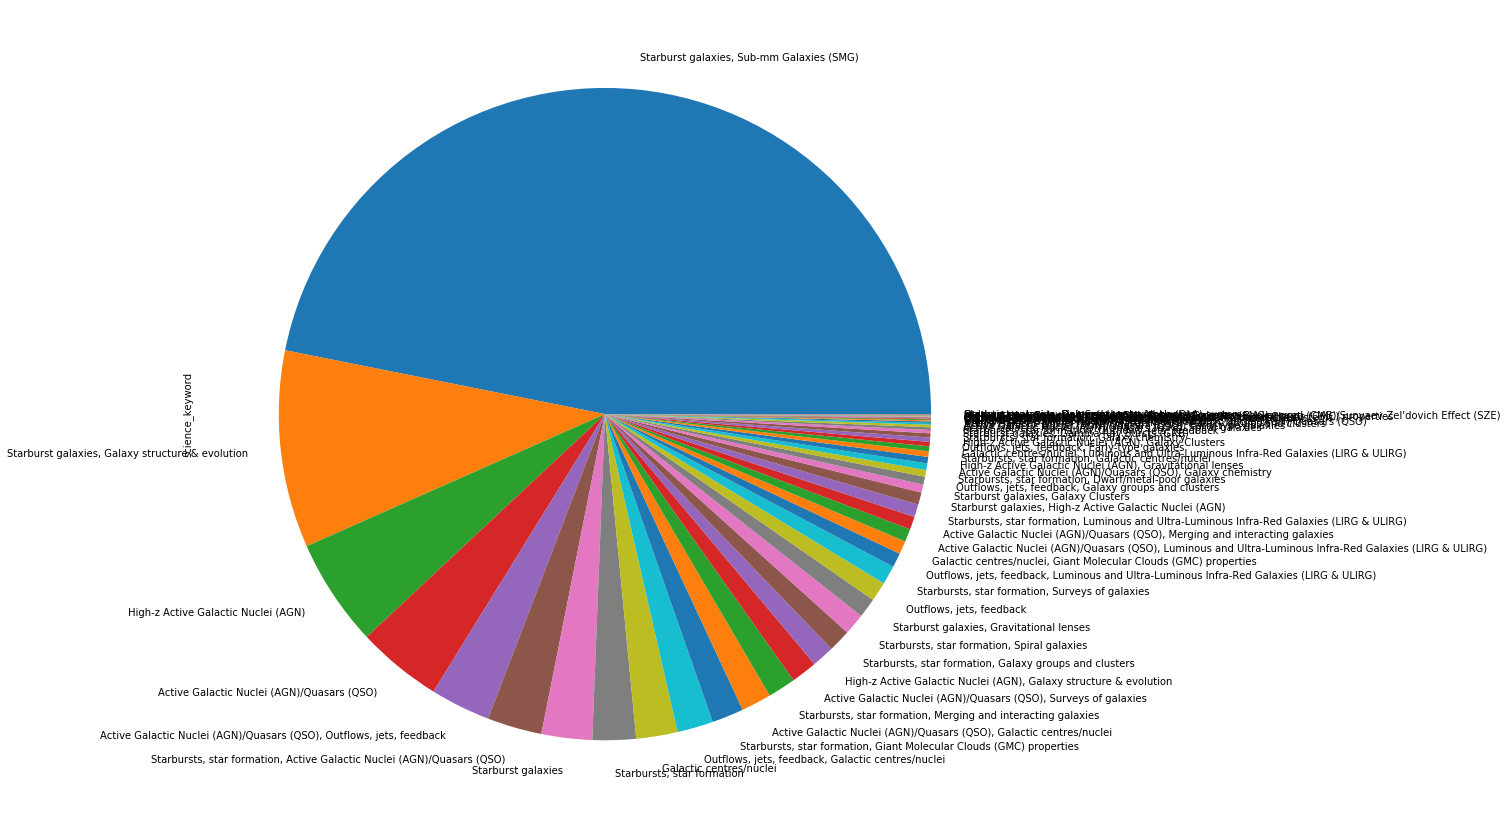

In [12]:
output_agn['science_keyword'].value_counts().plot.pie()

----------------------------

## Example 4b : How many sub-mm galaxies (science keyword) have been observed?

First, we investigate this question using the corresponding scientific keyboard.

In [ ]:
output_smgs_scikey = query_scikey('Sub-mm Galaxies (SMG)')

print('The scientific keyboard reports: ', len(output_smgs_scikey), 'Sub-mm Galaxies (SMG)')

              SELECT *              FROM ivoa.obscore              WHERE              science_observation = 'T'              AND              science_keyword like '%Sub-mm Galaxies (SMG)%'               


Second, we look for the keyboards in the proposal abstracts.

In [ ]:
query = """
        SELECT
         *
        FROM ivoa.obscore
        WHERE
          proposal_abstract like '%SMG%'
         OR
          proposal_abstract like 'sub-mm galaxies%'
        AND 
        science_observation = 'T'
         """           

output_smgs_abs= service.search(query).to_table().to_pandas()

In [127]:
print('The query by abstract reports: ', len(output_smgs_abs), 'observations of Sub-mm Galaxies (SMG)')

The query by abstract reports:  24827 observations of Sub-mm Galaxies (SMG)


We can now plot the position of these sub-mm galaxies observations:

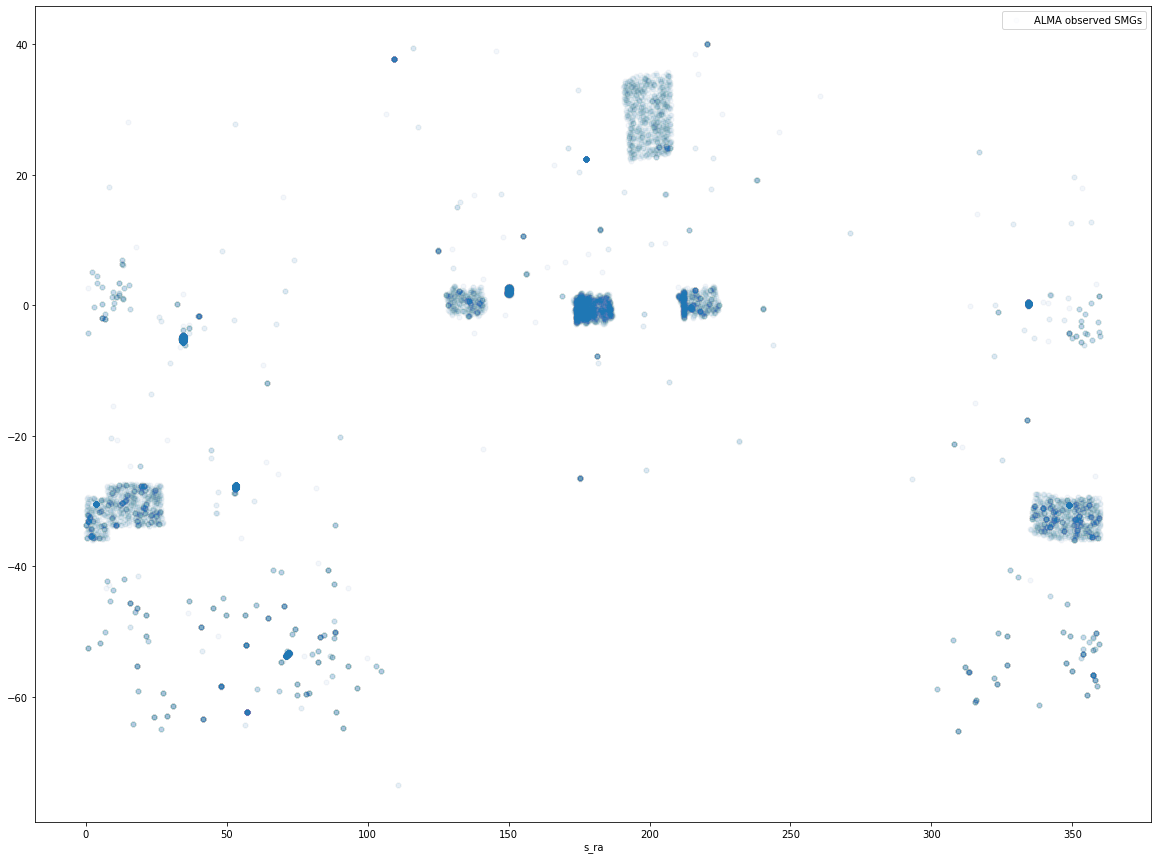

In [210]:
plt.rcParams["figure.figsize"] = (20,15)
output_smgs_scikey.plot(x='s_ra',y='s_dec', linestyle='', ms=5, marker='o', label='ALMA observed SMGs', alpha=0.01)

We now search for the sources (coordinate positions)which have been observed multiple times and order them by number of observations

----------------------------

## Example 4c : Which sub-mm galaxies have been observed the most with ALMA?



To answer this question, we first group the observations by (almost) identical coordinates in order to obtain all observations for specific sources:

In [319]:
output_smgs_scikey['s_ra_round']= np.round(output_smgs_scikey['s_ra'], 4) # since RA and DEC might deviate by 4 decimals ~ 1 arcsec
output_smgs_scikey['s_dec_round']= np.round(output_smgs_scikey['s_dec'], 4)
### data frame grouped by coordinates
df_gb = output_smgs_scikey.groupby(['s_ra_round', 's_dec_round']).count().sort_values(by= 'target_name', ascending=False)

We now compute the total exposure time corresponding toeach of this sources (groups of observations:

In [317]:
target_names=[]
exposure_times=[]
for i in range(len(df_gb['target_name'])):
    target=np.unique(output_smgs_scikey.loc[(output_smgs_scikey['s_ra_round']==df_gb.index[i][0]) & (output_smgs_scikey['s_dec_round']==df_gb.index[i][1])]['target_name'])
    target_names.append(target)
    ### Get total exposure times by adding all exposure time entries within each target group.
    exptime=np.sum(output_smgs_scikey.loc[(output_smgs_scikey['s_ra_round']==df_gb.index[i][0]) & (output_smgs_scikey['s_dec_round']==df_gb.index[i][1])]['t_exptime'])
    exposure_times.append(exptime)

We then plot the 50 targets (SMGs) with the longest total exposure times:

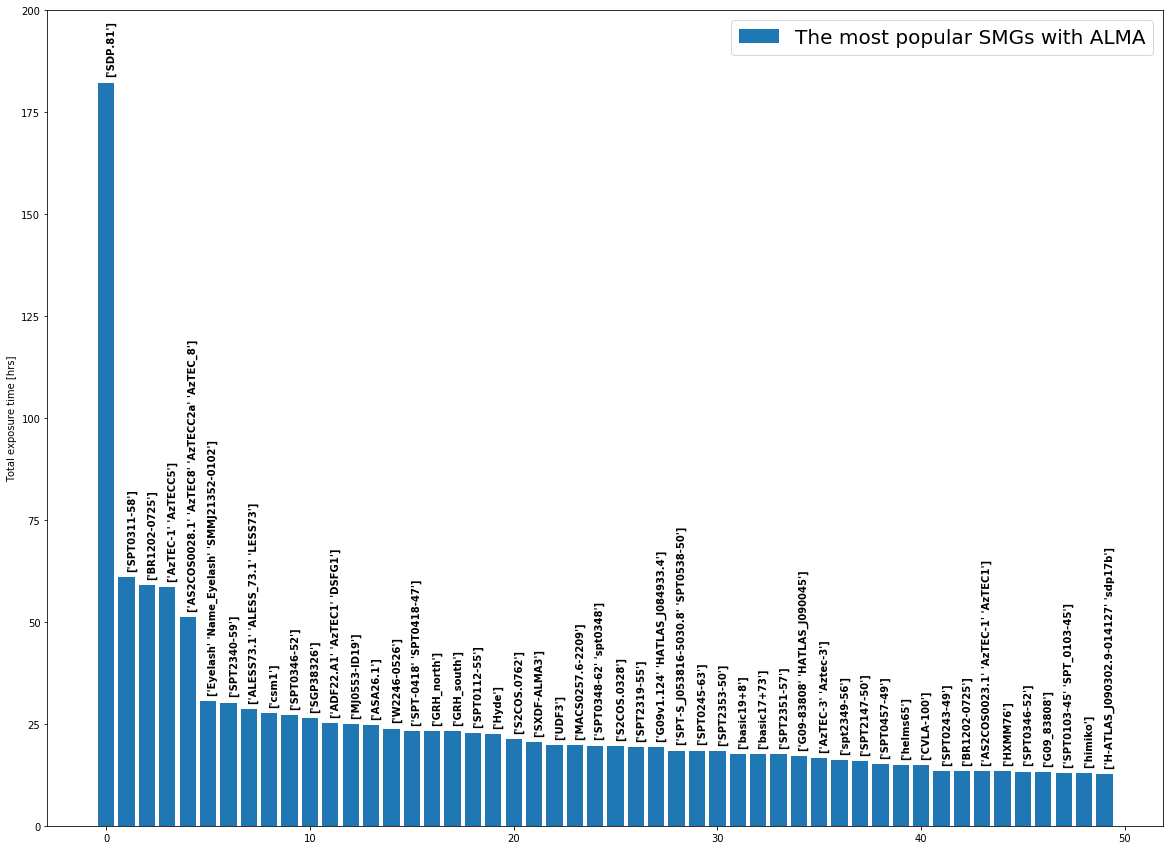

In [328]:
nr = 50
inds = (np.array(exposure_times)*-1).argsort()

### Plot exposure times
plt.bar(np.arange(nr),np.array(exposure_times)[inds][0:nr]/3600, align='center', label='The most popular SMGs with ALMA')

### Plot source names
for i in range(0,nr):
    plt.text(i,(np.array(exposure_times)[inds][0:nr]/3600)[i]+2 , str(np.array(target_names)[inds][i]), color='black', fontweight='bold', rotation=90 )
plt.ylim(0,200)
plt.ylabel('Total exposure time [hrs]')
plt.legend(fontsize=20)

----------------------------------------------

## Example 4d : How many quasars have been observed with ALMA?

### Spectral line observations

In [336]:
output_qsos_line = query_scikey_datatype('quasars', 'cube' )

len(np.unique(output_qsos_line['target_name']))


            SELECT
             *
            FROM ivoa.obscore
            WHERE
            science_keyword like '%quasars%'
            AND 
            science_observation = 'T'
            AND
            dataproduct_type = 'cube'
             


637

### Continuum observations

In [339]:
output_qsos_line = query_scikey_datatype('quasars', 'image' )

len(np.unique(output_qsos_line['target_name']))


            SELECT
             *
            FROM ivoa.obscore
            WHERE
            science_keyword like '%quasars%'
            AND 
            science_observation = 'T'
            AND
            dataproduct_type = 'image'
             


789